# Control theory. Course introduction.

## TP1. System modeling. State-space representation of dynamical systems.

## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

Please, submit your completed notebook **via Moodle before the beginning of the next session.**

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

## Ex.1: Open-loop vs Closed-loop system

### TODO

Provide one example of an open-loop control system and one for a closed-loop control system. What is the difference between those two?

## Ex.1: Vehicle Suspension System

Vehicle Suspension System

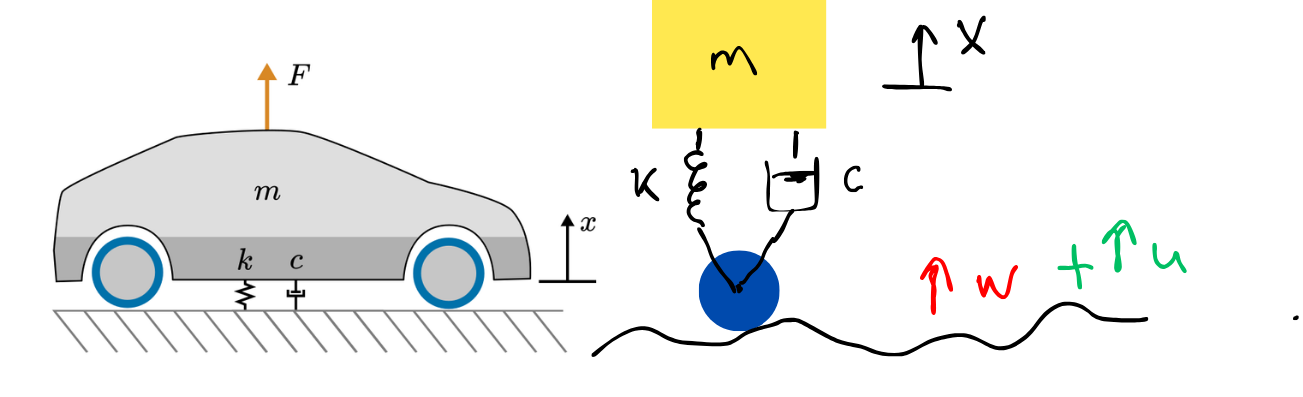

with the following system parameters:

    (m) mass 1.0 kg

    (k) spring constant 5.0 N/m

    (c) damping constant 2 Ns/m

### **Equation of Motion:**

For a mass-spring-damper system, the equation of motion can be derived using Newton's second law or by applying the principles of dynamics. The general form of the equation is:

$$
m \frac{d^2x}{dt^2} + c \frac{dx}{dt} + kx = u + w
$$

### **State-Space Representation:**

To convert the second-order differential equation into a system of first-order differential equations, we introduce the following state variables:
- Let $ x_1 = x $ (position),
- Let $ x_2 = \dot x $ (velocity).

The system becomes:

$$\dot x = Ax+Bu+Dw$$

where
state vector $x = (position, velocity)$, and state and control matrices are the following:
$$ A = \begin{pmatrix} 0&1\\ -\frac{k}{m}&-\frac{c}{m}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix},\ D =\begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix}$$

## TODO
1. Check on the implementation of a bang-bang controller provided below.

2. Implement a PID controller with parameters Kp = 400, Ki = 200, Kd = 50 that ensures that position of the mass ($y = [1,0]x$) tracks the zero reference input $r(t)=0.$

3. Let $x_0 = (0, 0).$ Let disturbance input $w(t)$ is given by a step function
    $$w = \left\{\begin{aligned}
        &0, \quad t <3.0\\
        &1.0,  \quad 3.0 \leq t < 7.0\\
        &0,  \quad t \geq 7
    \end{aligned}\right.$$
   Compare the trajectories of uncontrolled ($u(t) = 0$), bang-bang-, and PID-controlled systems.

In [24]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Basic Functions (Keep as is) ---
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    return (C @ solution.T) 

def BangBangController(A, B, D, C, u_const, ref, delay, w_func, T, x0):
    y_res = np.empty(x0.shape).reshape(-1,1)
    t0 = 0
    t1 = delay
    temp_T = T.copy()
    temp_x0 = x0.copy()
    while t1 < temp_T[-1]+delay:
        T_bang = temp_T[temp_T<=t1]
        temp_T = temp_T[T_bang.shape[0]-1:]
        u_func = lambda t: -u_const if C @ temp_x0 - ref > 0 else (u_const if C @ temp_x0 - ref < 0 else 0.0)
        sol = odeint(StateSpace, temp_x0, T_bang, args=(A, B, D, u_func, w_func)).T
        temp_x0 = sol[:,-1].flatten()
        t0 = t1
        t1 += delay
        y_res = np.hstack((y_res, sol[:,1:]))
    return C @ y_res  

# PID response (same simulation style, sampled each 'delay')
Kp, Ki, Kd = 400, 200, 50

# --- Optimized PID Logic ---
def pid_u(x, t):
    global integral_error, last_t
    # calculate exact time step
    dt = t - last_t if t > last_t else 0.0 
    
    error = 0 - x[0] # tracking zero reference
    integral_error += error * dt # integrate error
    derivative = -x[1] # velocity is state x[1]
    
    last_t = t # update time for next step
    return Kp * error + Ki * integral_error + Kd * derivative

def StateSpacePID(x, t, A, B, D, w_func):
    u = pid_u(x, t) # control law
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w_func(t)).flatten()

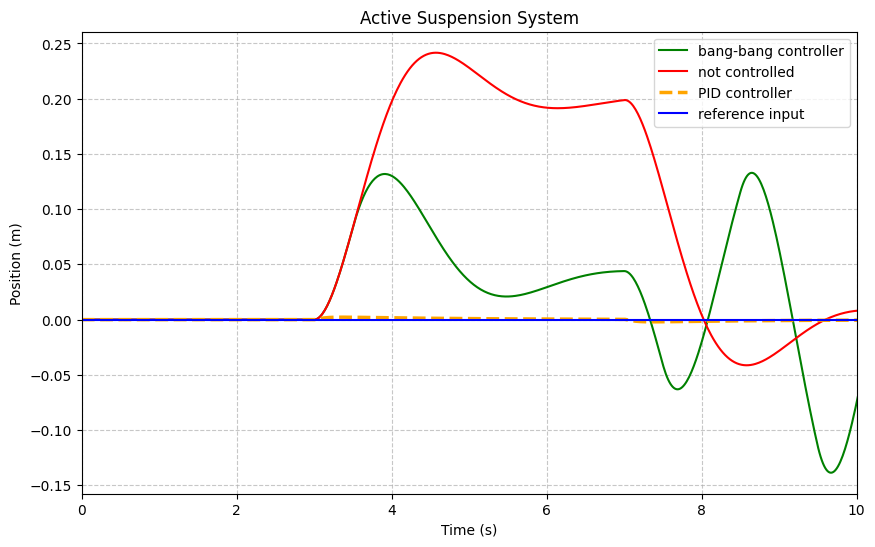

In [ ]:
# System parameters
m = 1
k = 5
c = 2
g = 9.8

A = np.array([[0, 1],
              [-k/m, -c/m]])  # Corrected c instead of rho

B = np.array([[0],
              [1/m]])  # Reshaped to column vecto
D = np.array([[0],
              [1/m]])  # Reshaped to column vector

C = np.array([[1, 0]])  # Output matrix

R = np.array([0])

# flatten() to convert to 1D array since scipy.integrate.odeint requires the state vector (x) to have shape (n,), not (n,1).
x0 = np.array([0, 0]).flatten() # Initial state

# Time settings
t0 = 0  # Initial time 
tf = 15# Final time
T = np.linspace(t0, tf, 1000)  # Time vector

def w_func(t):
    if t<= 3.0:
        return 0.0
    elif 3.0<= t and t<7.0:
        return 1.0
    else:
       return 0.0# Disturbance input

# Compute system response
u_const = 0.8
delay = 0.5
x_ref = 0.0
y_bang = BangBangController(A, B, D, C, u_const, x_ref, delay, w_func, T.copy(), x0.copy())




# 1. PID Simulation
integral_error, last_t = 0, 0 # reset globals
sol_pid = odeint(StateSpacePID, x0, T, args=(A, B, D, w_func))
y_pid = (C @ sol_pid.T)
def u_func(t):
    return 0.0

y_open = OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0)


# --- Plotting ---
plt.figure(figsize=(10,6))
plt.plot(T, y_bang[0,:], 'g-', label='bang-bang controller')
plt.plot(T, y_open[0,:], 'r-', label='not controlled')
plt.plot(T, y_pid[0,:], color='orange', linestyle='--', linewidth=2.5, label='PID controller')
plt.plot(T, T*0, 'b-', label='reference input')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim([0, 10])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.title('Active Suspension System')
plt.legend()
plt.show()

## DC Motor Speed: System Modeling

A common actuator in control systems is the DC motor. It directly provides rotary motion and, coupled with wheels or drums and cables, can provide translational motion. The electric equivalent circuit of the armature and the free-body diagram of the rotor are shown in the following figure.

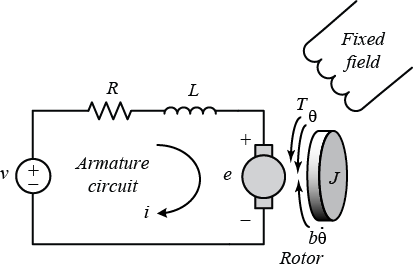

For this example, we will assume that the input of the system is the voltage source ($V$) applied to the motor's armature, while the output is the rotational speed of the shaft $\dot{\theta}$. The rotor and shaft are assumed to be rigid. We further assume a viscous friction model, that is, the friction torque is proportional to shaft angular velocity. We will assume that the magnetic field is constant and, therefore, that the motor torque is proportional (with constant $K_t$) to only the armature current. Let us remark that in SI units the motor torque and back emf constants are equal, that is, $K_t = K_e$;

The physical parameters for our example are:

    (J)   moment of inertia of the rotor     0.01 kg.m^2

    (b)     motor viscous friction constant    0.1 N.m.s

    (Ke)    electromotive force constant       0.01 V/rad/sec

    (Kt)    motor torque constant              0.01 N.m/Amp

    (R)     electric resistance                1 Ohm

    (L)     electric inductance                0.5 H
    

Let us suppose that the measured output of the system is the angular velocity of the rotor $\dot{\theta}$ and the current intensity $\dot{i}$. Then the state space model of the system is the following:
$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x=(\dot{\theta}, i)$, control vector $u=V$, and state and control matrices are the following

$$ A = \begin{pmatrix} -\frac{b}{J}&\frac{K}{J}\\ -\frac{K}{L}&-\frac{R}{L}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{L} 
\end{pmatrix}$$

Let us suppose that we only interested in rotation speed (angular velocity of the rotor), i.e. $C=(1,0)$.

## TODO

1. For a 1-rad/sec step reference, the design a PID controller that satisfies the following criteria are the following.

    Settling time less than 2 seconds

    Overshoot less than 5%

    Steady-state error less than 1%
   
3. Tune a PID controller using the Ziegler-Nichols Methods.

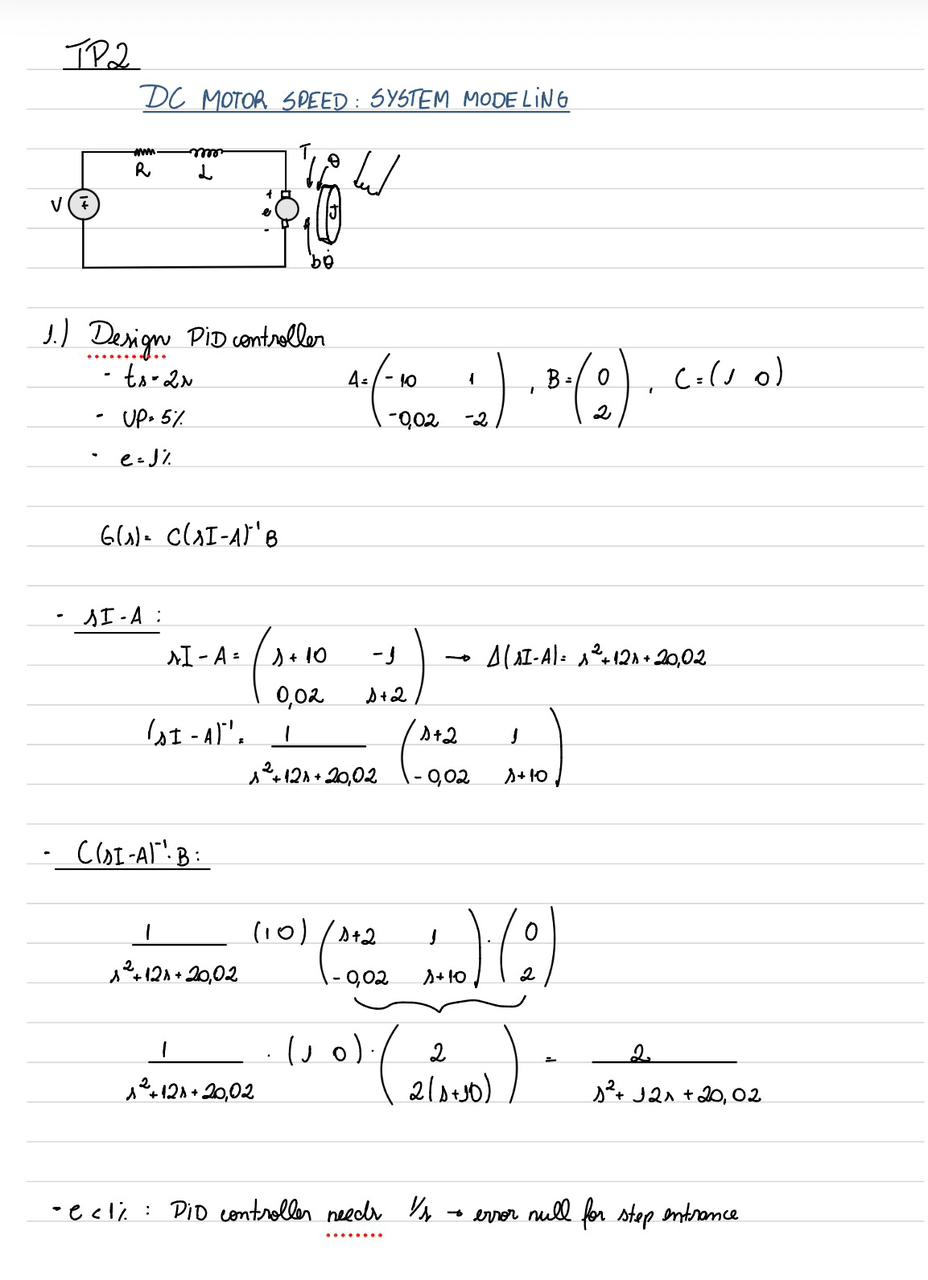
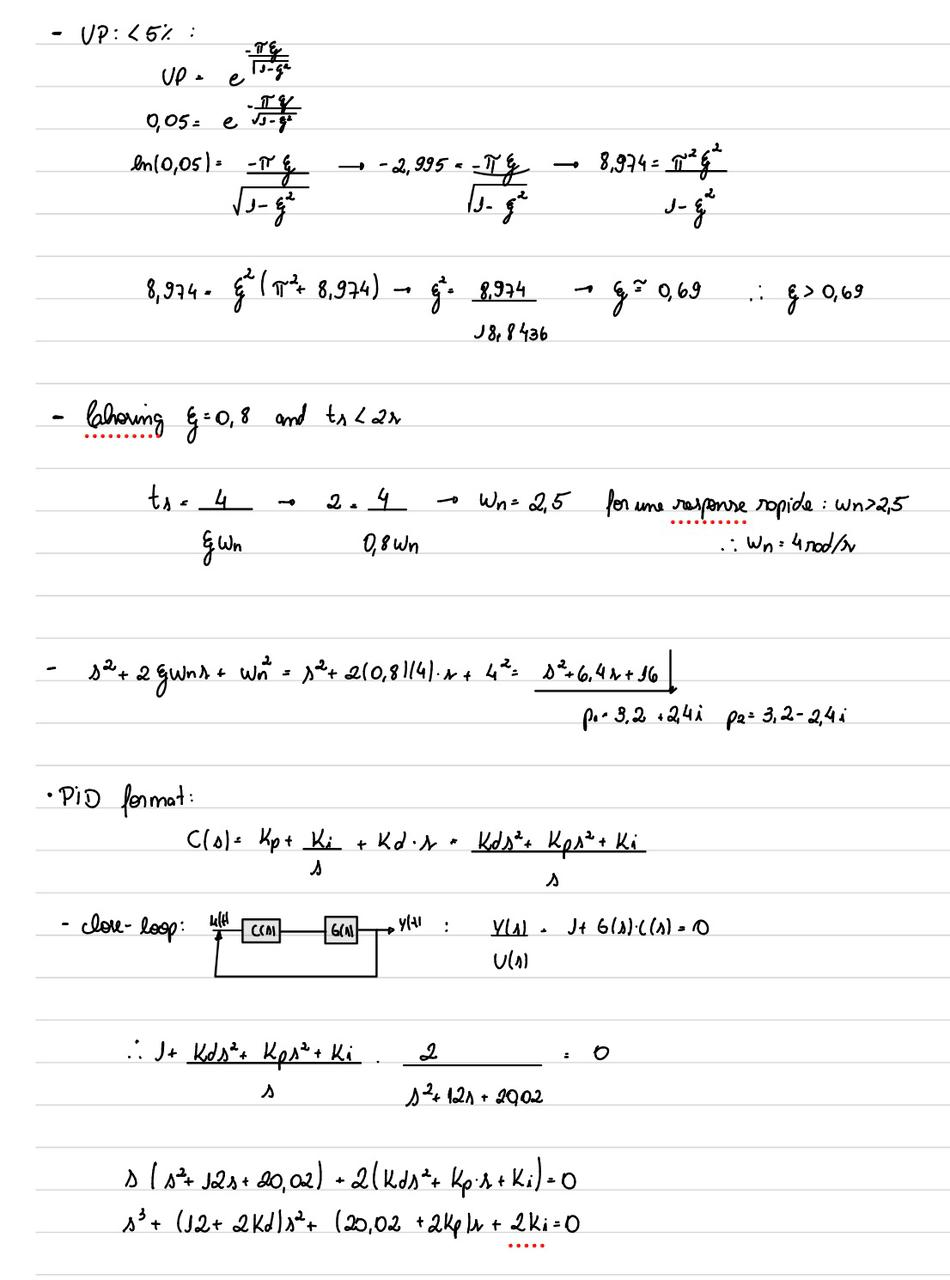
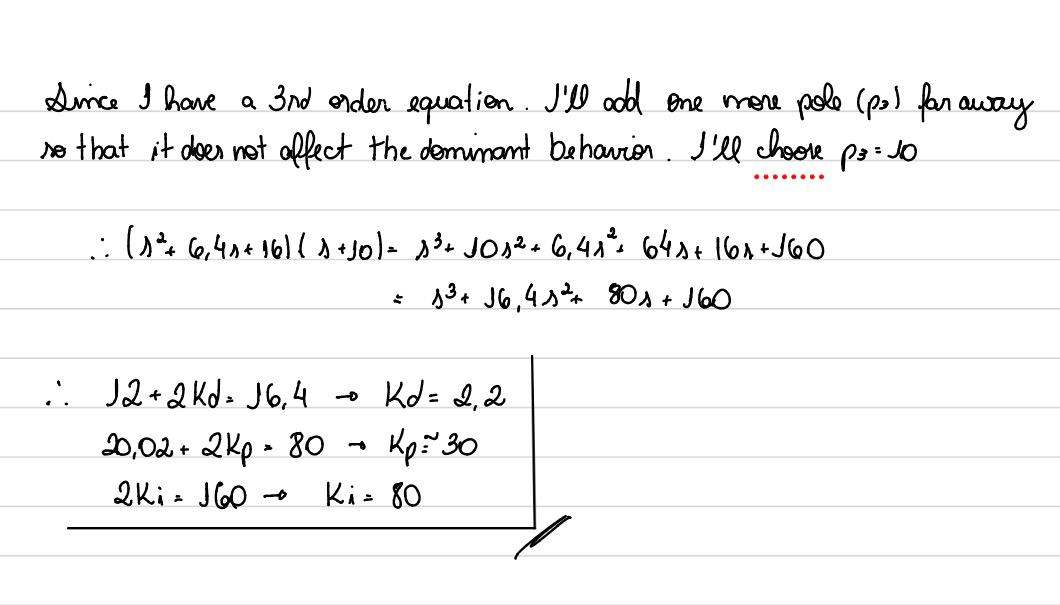



System Transfer Function (Plant):
TransferFunctionContinuous(
array([2.]),
array([ 1.  , 12.  , 20.02]),
dt: None
)

Ziegler-Nichols Tuning (Estimated):
Kp: 167.76, Ki: 1568.09, Kd: 4.49


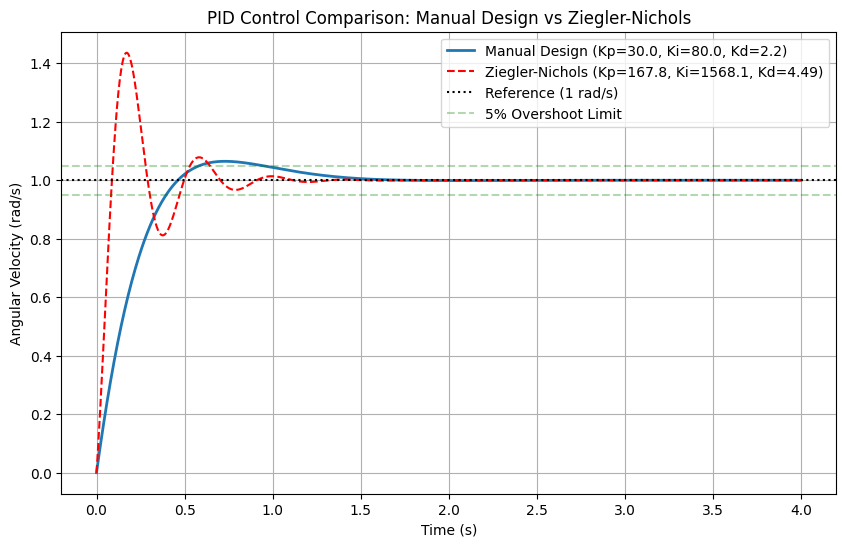

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ==========================================
# SYSTEM DEFINITION
# ==========================================
# Physical parameters
J = 0.01   # Moment of inertia
b = 0.1    # Viscous friction constant
K = 0.01   # Torque/Back EMF constant
R = 1      # Armature resistance
L = 0.5    # Armature inductance

# State Matrices
A = [[-b/J, K/J], 
     [-K/L, -R/L]]
B = [[0], 
     [1/L]]
C = [1, 0]
D = [0]

# Create state-space system and convert to Transfer Function
sys_ss = signal.StateSpace(A, B, C, D)
sys_tf = sys_ss.to_tf()

print("System Transfer Function (Plant):")
print(sys_tf)

# Simulation time
t = np.linspace(0, 4, 1000)

# ==========================================
# PART 1 & 2: MANUAL DESIGN SIMULATION
# ==========================================
# Manually calculated gains (Pole Placement)
Kp_man = 30.0
Ki_man = 80.0
Kd_man = 2.2

# PID Transfer Function: C(s) = (Kd*s^2 + Kp*s + Ki) / s
num_pid = [Kd_man, Kp_man, Ki_man]
den_pid = [1, 0]
pid_tf = signal.TransferFunction(num_pid, den_pid)

# Closed Loop: T = (C*G) / (1 + C*G)
# Multiply TFs (Controller * Plant) to get Open Loop
open_loop = signal.convolve(sys_tf.num, pid_tf.num), signal.convolve(sys_tf.den, pid_tf.den)

# Close the loop (Unity feedback)
# num_cl = num_ol
# den_cl = num_ol + den_ol
num_cl = open_loop[0]
den_cl = np.polyadd(open_loop[0], open_loop[1])

sys_cl_manual = signal.TransferFunction(num_cl, den_cl)

# Step Response
t_man, y_man = signal.step(sys_cl_manual, T=t)

# ==========================================
# PART 3: ZIEGLER-NICHOLS (REACTION CURVE METHOD)
# ==========================================
# Since this is an ideal 2nd order system, it doesn't oscillate unstably 
# (Ultimate Gain method fails). We use the Reaction Curve method (Open Loop), 
# approximating the system as First Order Plus Dead Time (FOPDT).

# 1. Simulate step response in open loop
t_ol, y_ol = signal.step(sys_tf, T=t)

# 2. Find maximum slope (tangent)
dy = np.diff(y_ol) / np.diff(t_ol)
max_slope_idx = np.argmax(dy)
max_slope = dy[max_slope_idx]
time_at_max_slope = t_ol[max_slope_idx]
val_at_max_slope = y_ol[max_slope_idx]

# 3. Calculate L (Lag/Delay) and T (Time Constant) by intercepting the tangent
# Tangent equation: y = m*(t - t0) + y0
# X-axis intercept (y=0) -> t_intercept = t0 - y0/m
L_zn = time_at_max_slope - (val_at_max_slope / max_slope)

if L_zn < 0: L_zn = 0.001 # Numerical protection in case L is too small

# The final value of the plant is K_static = 2/20.02 = 0.0999
K_plant = y_ol[-1]

# The upper intercept (y = K_plant) defines T
T_zn = (K_plant / max_slope) 

# 4. Ziegler-Nichols Formulas
# Kp = 1.2 * (T / (L * K_plant))
# Ti = 2 * L
# Td = 0.5 * L
# PID Gains: Kp, Ki = Kp/Ti, Kd = Kp*Td

Kp_zn = 1.2 * (T_zn / (L_zn * K_plant))
Ti_zn = 2 * L_zn
Td_zn = 0.5 * L_zn

Ki_zn = Kp_zn / Ti_zn
Kd_zn = Kp_zn * Td_zn

print(f"\nZiegler-Nichols Tuning (Estimated):")
print(f"Kp: {Kp_zn:.2f}, Ki: {Ki_zn:.2f}, Kd: {Kd_zn:.2f}")

# ZN PID Simulation
num_pid_zn = [Kd_zn, Kp_zn, Ki_zn]
pid_tf_zn = signal.TransferFunction(num_pid_zn, den_pid)
ol_zn = signal.convolve(sys_tf.num, pid_tf_zn.num), signal.convolve(sys_tf.den, pid_tf_zn.den)
num_cl_zn = ol_zn[0]
den_cl_zn = np.polyadd(ol_zn[0], ol_zn[1])
sys_cl_zn = signal.TransferFunction(num_cl_zn, den_cl_zn)

t_zn, y_zn = signal.step(sys_cl_zn, T=t)

# ==========================================
# PLOTTING
# ==========================================
plt.figure(figsize=(10, 6))

# Plot Manual Design
plt.plot(t_man, y_man, label=f'Manual Design (Kp={Kp_man}, Ki={Ki_man}, Kd={Kd_man})', linewidth=2)

# Plot Ziegler-Nichols
plt.plot(t_zn, y_zn, '--', label=f'Ziegler-Nichols (Kp={Kp_zn:.1f}, Ki={Ki_zn:.1f}, Kd={Kd_zn:.2f})', color='red')

# Reference lines
plt.axhline(1.0, color='k', linestyle=':', label='Reference (1 rad/s)')
plt.axhline(1.05, color='g', linestyle='--', alpha=0.3, label='5% Overshoot Limit')
plt.axhline(0.95, color='g', linestyle='--', alpha=0.3)

plt.title('PID Control Comparison: Manual Design vs Ziegler-Nichols')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid(True)
plt.show()

## EX. 3 Inverted Pendulum

The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.

![inverted_pendulum.png](attachment:0a81c6f5-4431-4bf0-a50c-133da7e550cc.png)

Let us consider the system with the following system parameters
    
    (M)       mass of the cart                         0.5 kg
    
    (m)       mass of the pendulum                     0.2 kg
    
    (l)       length to pendulum center of mass        0.3 m
    
    (b)       coefficient of friction for cart         0.1 N/m/sec
    
    (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
    
    (F)       force applied to the cart
    
    (y)       cart position coordinate
    
    (theta)   angle between the pendulum and the vertical axis

## TODO
    
The inverted pendulum on the cart can be modeled as follows

$$(M+m)\ddot{y} + b\dot{y} + ml\ddot{\theta}\cos\theta -ml\dot\theta^2\sin(\theta) = F$$

$$ml\cos(\theta)\ddot{y} + (I+ml^2)\ddot{\theta} - mgl\sin\theta = 0$$    

1. Check on the code below showing that a linearalised model of the system is the following

$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x = (y,\theta,\dot{y},\dot{\theta})$, control vector $u=F$.

$$\left[\begin{array}{c}\dot{y} \\ \dot{\theta} \\ \ddot{y} \\ \ddot{\theta}\end{array}\right]=
\left[\begin{array}{cccc}0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 1 \\ 
0 & \frac{-g m^2 l^2}{I(M+m)+M m l^2} & \frac{-\left(I+m l^2\right) b}{I(M+m)+M m l^2} & 0 \\ 
0 & \frac{m g l(M+m)}{I(M+m)+M m l^2} & \frac{m l b}{I(M+m)+M m l^2} & 0\end{array}\right]
\left[\begin{array}{c}y \\ \theta \\ \dot{y} \\ \dot{\theta}\end{array}\right]+
\left[\begin{array}{c}0 \\ 0 \\ \frac{I+m l^2}{I(M+m)+M m l^2} \\ \frac{-m l}{I(M+m)+M m l^2}\end{array}\right] u$$

$$
\mathbf{y}=
\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right]
\left[\begin{array}{c}y \\ \theta \\ \dot{y} \\ \dot{\theta}\end{array}\right]$$

3) Design a PID controller corresponding to the reference signal $\theta_{ref}$ = 0 rad, while supposing that the angle is subject to a constant disturbance $w(t) = 0.1$

4) Plot the position of the cart for the corresponding closed-loop system. What conclusion could you make?

In [18]:
import sympy as sp
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f3, f2, f4]) #CORRECTION: order of f2 and f3 was swapped in the original code, now it's consistent with the state vector order (y, theta, y1, theta1)

# Define state and control variables
variables_x = sp.Matrix([y,theta,y1,theta1]) #corrected order to match state vector (y, theta, y1, theta1)
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))


--- 2. Starting Numerical Simulation ---


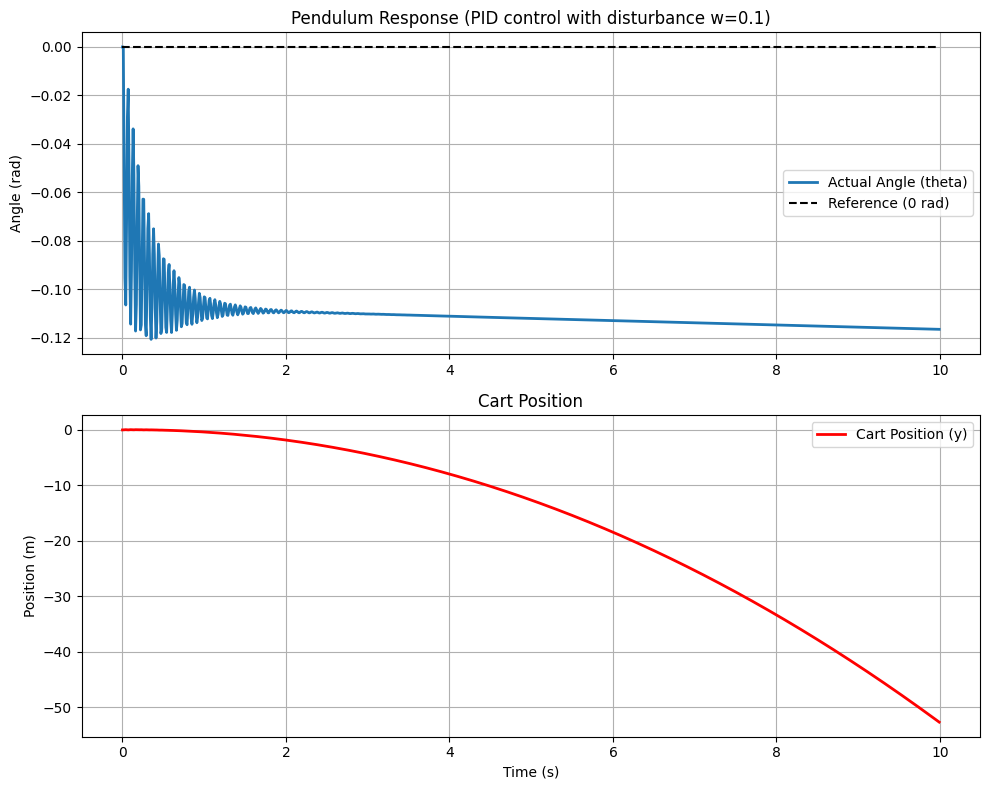

In [22]:
# ======================================================
# PART 2: NUMERICAL SIMULATION OF PID
# ======================================================
print("\n--- 2. Starting Numerical Simulation ---")

# Physical Parameters
params = {
    M: 0.5,
    m: 0.2,
    b: 0.1,
    l: 0.3,
    I: 0.006,
    g: 9.81
}

# Convert symbolic matrices to numeric (numpy)
A_num = np.array(jacobian_A.subs(params)).astype(np.float64)
B_num = np.array(jacobian_B.subs(params)).astype(np.float64)

# PID Controller Parameters
Kp = -100.0
Ki = -2.0  # small integral action
Kd = -20.0
theta_ref = 0.0

# Simulation Setup
t_end = 10.0
dt = 0.01
t = np.arange(0, t_end, dt)
n_steps = len(t)

# History vectors
x_history = np.zeros((n_steps, 4)) # [y, theta, y_dot, theta_dot]
u_history = np.zeros(n_steps)

# Initial Condition: Pendulum upright, stationary
x_current = np.array([0.0, 0.0, 0.0, 0.0])

# PID variables
integral_error = 0.0
prev_error = 0.0

# Simulation Loop
for i in range(n_steps):
    # 1. Measurement with disturbance
    # Sensor reads the real angle + disturbance w(t) = 0.1
    # This misleads the controller into thinking the pendulum is tilted
    disturbance_w = 0.1
    theta_measured = x_current[1] + disturbance_w
    
    # 2. Error calculation
    error = theta_ref - theta_measured
    
    # 3. PID terms
    integral_error += error * dt
    derivative_error = (error - prev_error) / dt
    
    # 4. Control signal (Force F)
    F_control = Kp*error + Ki*integral_error + Kd*derivative_error
    
    # Force saturation (motor physical limit, optional but realistic)
    F_control = np.clip(F_control, -100, 100)
    
    # 5. System evolution (using linear model x_dot = Ax + Bu)
    # Simple Euler integration (sufficient for small dt)
    x_dot = A_num @ x_current + B_num.flatten() * F_control
    x_new = x_current + x_dot * dt
    
    # Store data
    x_history[i, :] = x_current
    u_history[i] = F_control
    
    # Update for next step
    x_current = x_new
    prev_error = error

# ======================================================
# PART 3: PLOTTING RESULTS
# ======================================================
y_pos = x_history[:, 0]
theta_pos = x_history[:, 1]

plt.figure(figsize=(10, 8))

# Plot 1: Pendulum Angle
plt.subplot(2, 1, 1)
plt.plot(t, theta_pos, label='Actual Angle (theta)', linewidth=2)
plt.plot(t, np.zeros_like(t), 'k--', label='Reference (0 rad)')
plt.title('Pendulum Response (PID control with disturbance w=0.1)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True)

# Plot 2: Cart Position
plt.subplot(2, 1, 2)
plt.plot(t, y_pos, color='r', label='Cart Position (y)', linewidth=2)
plt.title('Cart Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()